# Implementación de un modelo de deep learning (Portafolio Implementación)

#### Paula Sophia Santoyo Arteaga
#### A01745312

---

**Instrucciones**

- Implementa una arquitectura de deep learning para solucionar el problema. Lo que se busca es que apliques correcta y efectivamente las técnicas vistas en el módulo.
- Analiza los resultados de tu modelo set de pruebas y validación.
- Mejora tu modelo usando técnicas de regularización, ajustando hiper parámetros, modificando la arquitectura de tu modelo o buscando otro modelo.
- Documenta y explica cuáles son los cambios que funcionaron y por qué funcionaron.
- Prueba tu implementación con un set de datos y realiza algunas predicciones. Las predicciones las puedes correr en consola o las puedes implementar con una interfaz gráfica apoyándote en los visto en otros módulos.

---

## **Introducción**

Este análisis tiene como objetivo desarrollar un modelo para evaluar el sentimiento de las reseñas de películas de Marvel, con énfasis en Spider-Man: No Way Home. Se busca analizar la polaridad y subjetividad de las reseñas, permitiendo una comprensión más profunda de cómo los espectadores perciben la película. Este enfoque sienta las bases para un modelo más amplio que pueda aplicarse a reseñas de otras películas de Marvel en el futuro.

In [1]:
# Importar librerias

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Cargar conjunto de datos
df = pd.read_csv('movieReviews.csv')

# Cambiar el nombre de la columna
df['User_Rating'] = df["User's Rating out of 10"]
df = df.drop(columns=["User's Rating out of 10"])


df.head()

,Date of Review,User,Usefulness Vote,Total Votes,Review Title,Review,User_Rating
0,19 March 2022,Neptune165,313,445,I consider myself to be a big fan of Marvel an...,Awful movie. The plot sucked and had awful pac...,5
1,18 December 2021,BandSAboutMovies,1373,2145,Somehow better than Endgame,It's hard to discuss this movie and not get in...,10
2,21 December 2021,IPyaarCinema,380,596,Nonsense And Nostalgia,Review By Kamal KI don't think this film was w...,4
3,16 December 2021,jack_o_hasanov_imdb,611,995,Just Awesome !,It was very enjoyable to watch in the cinema. ...,9
4,12 March 2022,paul_haakonsen,202,330,Definitely one for the fans...,"Right, well I am by no means a fan of superher...",6


## **Datos**
Para los datos podemos observar que se tienen las columnas: Date of Review, User, Usefulness Vote, Total Votes, Review Title Review y User_Rating. Lo primero que se hizo fue cambiar el nombre de User's Rating out of 10 por User_Rating para que fuera más sencillo identificar la columna. Para poder saber si la reseña era positiva o negativa se tuvo que crear una columna de Sentiment en la cual se colocó 0 si era un comentario negativo y 1 si era positivo. Para definir esto se tomó como buena película si el User_Rating era arriba de 7 de lo contrario era mala.


In [2]:
# Preprocesamiento de datos
max_sequence_length = 5000
vocab_size = 10000

# Generar la columna Sentiment
threshold = 7
df['Sentiment'] = (df['User_Rating'] >= threshold).astype(int)

conteo_sentimientos = df['Sentiment'].value_counts()

# Imprimir canidad de reseñas
print("Cantidad de reseñas positivas (1):", conteo_sentimientos[1])
print("Cantidad de reseñas negativas (0):", conteo_sentimientos[0])

Cantidad de reseñas positivas (1): 4793
Cantidad de reseñas negativas (0): 1168


Se cuentan con más reseñas positivas por lo que puede haber un sesgo al momento de hacer el modelo por lo que se tomarán la misma cantidad de muestras para las positivas como las negativas.

In [3]:
# Separar reseñas positivas y negativas
positivas = df[df['Sentiment'] == 1]
negativas = df[df['Sentiment'] == 0]

# Equilibrar las clases tomando la misma cantidad de muestras de cada clase
min_samples = min(len(positivas), len(negativas))
positivas = positivas.sample(min_samples, random_state=42)
negativas = negativas.sample(min_samples, random_state=42)

# Combinar las clases equilibradas
df_balanced = pd.concat([positivas, negativas])

# Mezclar el conjunto de datos equilibrado
df_balanced = shuffle(df_balanced, random_state=42)

conteo_sentimientos = df_balanced['Sentiment'].value_counts()

# Verificar misma cantidad de reseñas
print("Cantidad de reseñas positivas (1):", conteo_sentimientos[1])
print("Cantidad de reseñas negativas (0):", conteo_sentimientos[0])


Cantidad de reseñas positivas (1): 1168
Cantidad de reseñas negativas (0): 1168


In [4]:
# Tokenización y vectorización de texto
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_balanced['Review'])
sequences = tokenizer.texts_to_sequences(df_balanced['Review'])
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Etiquetas de sentimiento
labels = df_balanced['Sentiment'].values


Se implementa la separación de los datos de entrenamiento y los de prueba


## **Desarrollo del modelo**
Para el modelo estoy ocupando una red neuronal recurrente (RNN). Comienza con una capa de embedding que convierte las palabras en vectores densos. Luego, sigue con una capa GRU que ayuda a capturar los patrones en las secuencias de datos. Finalmente, hay una capa densa de salida con una función de activación sigmoide que sirve para predecir la polaridad de la reseña (positiva o negativa).
Se entrena en datos de entrenamiento y se evalúa en un conjunto de validación (prueba). Los resultados se evalúan utilizando la precisión como métrica.

In [5]:
# División del dataset en train y test
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Configuración de semilla aleatoria
tf.random.set_seed(42)


# Construcción del modelo RNN con Embedding y GRU
embed_size = 128
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_sequence_length),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Entrenamiento del modelo
history = model.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=32)


Epoch 1/5
47/47 [==============================] - 515s 11s/step - loss: 0.6796 - accuracy: 0.5542 - val_loss: 0.5459 - val_accuracy: 0.7834
Epoch 2/5
47/47 [==============================] - 519s 11s/step - loss: 0.4444 - accuracy: 0.7999 - val_loss: 0.4098 - val_accuracy: 0.8316
Epoch 3/5
47/47 [==============================] - 519s 11s/step - loss: 0.1779 - accuracy: 0.9344 - val_loss: 0.4124 - val_accuracy: 0.8422
Epoch 4/5
47/47 [==============================] - 527s 11s/step - loss: 0.0500 - accuracy: 0.9839 - val_loss: 0.5549 - val_accuracy: 0.8262
Epoch 5/5
47/47 [==============================] - 522s 11s/step - loss: 0.0218 - accuracy: 0.9953 - val_loss: 0.6174 - val_accuracy: 0.8342


## **Resultados**

In [6]:
# Evaluación del modelo en test
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Exactitud en el conjunto de prueba:", test_acc)

15/15 [==============================] - 22s 1s/step - loss: 0.8382 - accuracy: 0.8077
Exactitud en el conjunto de prueba: 0.807692289352417


In [7]:
# Realizar predicciones en test
predictions = model.predict(x_test)

predicted_labels = ["positivo" if pred >= 0.7 else "negativo" for pred in predictions]
for i in range(10):
    print(f"\nReview {i + 1}\n Text: {tokenizer.sequences_to_texts([x_test[i]])[0]}\n Predicción: {predicted_labels[i]}\n Probabilidad: {predictions[i][0]}")



15/15 [==============================] - 21s 1s/step

Review 1
 Text: i don't think any of the new phase four marvel movies are bad i just don't think they need to exist after endgame perfectly wrapped everything up this movie changes that introducing new concepts for the mcu to play with and delivering fan service in a way that doesn't feel pandering it also has some unexpected moments spread throughout that surprised me and everyone one else watching needless to say this is the best one in the mcu's spider man trilogy and i'm glad that we were able to see all of these fun characters one more time
 Predicción: positivo
 Probabilidad: 0.9954739212989807

Review 2
 Text: don't t put up your expectation too high overhyped and pretty dull i can say the plot well but predictable at the same time i was bored till the end the movie suitable for teenage girl from age 10 to 19
 Predicción: negativo
 Probabilidad: 0.00016352815146092325

Review 3
 Text: villains are not in the least bit threate


## **Ajuste del modelo**
El modelo modificado incorpora un poco más de complejidad ya que incluye múltiples capas GRU, capas de dropout que sirven para la regularización y de esta forma evitar el sobreajuste además de que también se agregaron capas densas adicionales. Con esto es posible analizar patrones más complejos en las secuencias de reseñas y mejorar la capacidad del modelo para generalizar.

In [8]:
# Construcción del modelo RNN mejorado con Embedding, GRU, y recurrent dropout
embed_size = 128
model_modified = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_sequence_length),
    tf.keras.layers.GRU(128, return_sequences=True, recurrent_dropout=0.2),
    tf.keras.layers.GRU(64, recurrent_dropout=0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_modified.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Entrenamiento del modelo
history_modified = model_modified.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
47/47 [==============================] - 1488s 31s/step - loss: 0.6666 - accuracy: 0.5669 - val_loss: 0.5277 - val_accuracy: 0.7647
Epoch 2/5
47/47 [==============================] - 1475s 31s/step - loss: 0.3684 - accuracy: 0.8407 - val_loss: 0.4104 - val_accuracy: 0.8289
Epoch 3/5
47/47 [==============================] - 1474s 31s/step - loss: 0.1487 - accuracy: 0.9431 - val_loss: 0.5249 - val_accuracy: 0.7620
Epoch 4/5
47/47 [==============================] - 1478s 31s/step - loss: 0.0602 - accuracy: 0.9819 - val_loss: 0.7008 - val_accuracy: 0.7968
Epoch 5/5
47/47 [==============================] - 1477s 31s/step - loss: 0.0208 - accuracy: 0.9913 - val_loss: 0.8445 - val_accuracy: 0.8128


## **Resultados**


In [9]:
# Evaluación del modelo en el conjunto de prueba
test_loss, test_acc = model_modified.evaluate(x_test, y_test)
print("Exactitud en el conjunto de prueba:", test_acc)

# Realizar predicciones en el conjunto de prueba
predictions = model_modified.predict(x_test)
predicted_labels = ["positivo" if pred >= 0.7 else "negativo" for pred in predictions]
for i in range(10):
    print(f"Review {i + 1}\n Text: {tokenizer.sequences_to_texts([x_test[i]])[0]}\n Predicción: {predicted_labels[i]}\n Probabilidad: {predictions[i][0]}")



15/15 [==============================] - 40s 3s/step - loss: 0.8132 - accuracy: 0.7949
Exactitud en el conjunto de prueba: 0.7948718070983887
15/15 [==============================] - 40s 3s/step
Review 1
 Text: i don't think any of the new phase four marvel movies are bad i just don't think they need to exist after endgame perfectly wrapped everything up this movie changes that introducing new concepts for the mcu to play with and delivering fan service in a way that doesn't feel pandering it also has some unexpected moments spread throughout that surprised me and everyone one else watching needless to say this is the best one in the mcu's spider man trilogy and i'm glad that we were able to see all of these fun characters one more time
 Predicción: positivo
 Probabilidad: 0.9996885061264038
Review 2
 Text: don't t put up your expectation too high overhyped and pretty dull i can say the plot well but predictable at the same time i was bored till the end the movie suitable for teenage g

## **Curvas de aprendizaje**

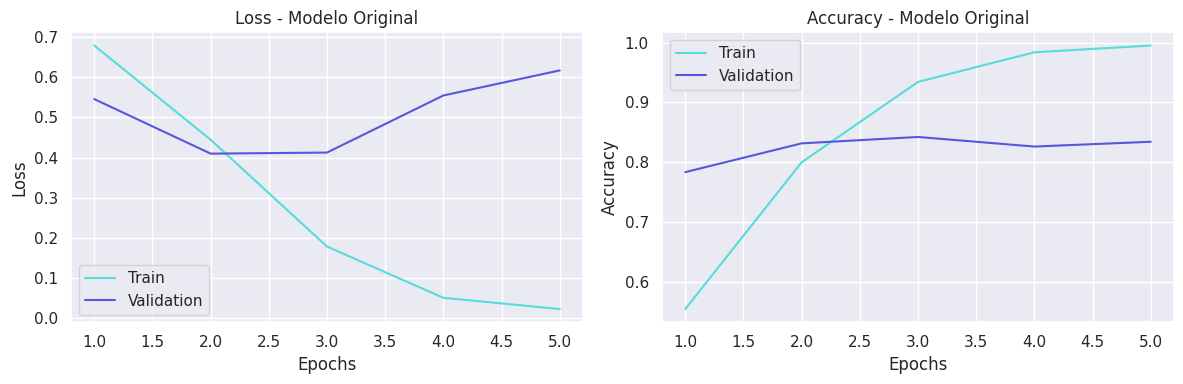

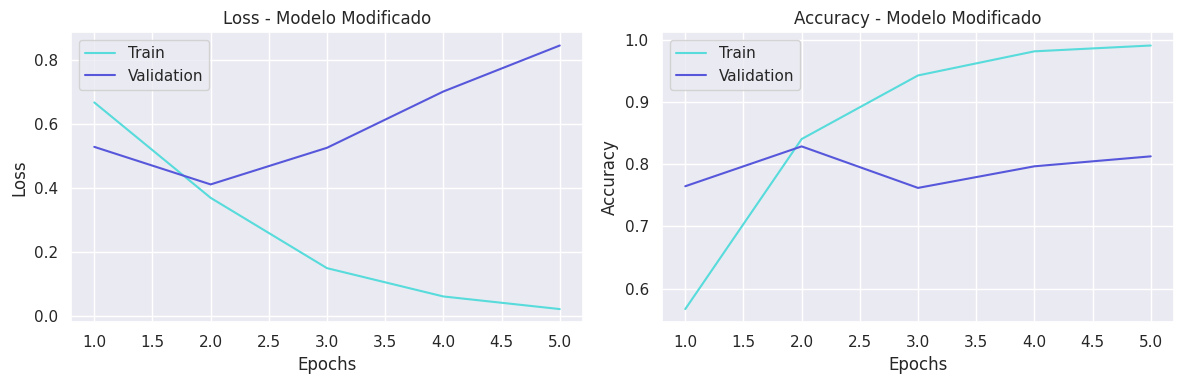

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
colors = sns.hls_palette(h=.5)

# Función para visualizar la curva de aprendizaje
def plot_learning_curve(history, title):
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Train', color=colors[0])
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation', color=colors[1])
    plt.title('Loss - ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Train', color=colors[0])
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation', color=colors[1])
    plt.title('Accuracy - ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizar curva de aprendizaje para el modelo original
plot_learning_curve(history, 'Modelo Original')

# Visualizar curva de aprendizaje para el modelo modificado
plot_learning_curve(history_modified, 'Modelo Modificado')



## **Predicciones**


In [11]:
# Realizar predicciones
sample_review = ["I was really looking forward to Spider-Man: No Way Home, but it left me feeling underwhelmed. The plot was overly convoluted, and the constant introductions of new characters left little room for character development. It had its moments, but overall, it didn't live up to the hype.",
                 "Spider-Man: No Way Home exceeded all my expectations. The action sequences were breathtaking, and the way they brought back familiar characters from previous Spider-Man films was pure nostalgia. This movie is a must-see for any Marvel fan."]
sample_sequences = tokenizer.texts_to_sequences(sample_review)
sample_data = pad_sequences(sample_sequences, maxlen=max_sequence_length)
prediction = model.predict(sample_data)
prediction_mod = model_modified.predict(sample_data)


predicted_labels = ["positivo" if pred > 0.7 else "negativo" for pred in prediction]
predicted_labels_mod = ["positivo" if pred > 0.7 else "negativo" for pred in prediction_mod]


for rev in range (len(sample_review)):
    print(f"\nReview {rev + 1}\n")
    print("Text:", sample_review[rev])

    print("\n--- BEFORE ADJUSTING HYPERPARAMETERS ---\n")
    print("Prediction:", prediction[rev][0])
    print("Sentiment prediction:", predicted_labels[rev])

    print("\n--- AFTER ADJUSTING HYPERPARAMETERS ---\n")

    print("Prediccion mod:", prediction_mod[rev][0])
    print("Predicción de sentimiento mod:", predicted_labels_mod[rev])

    print("------------------------------")



1/1 [==============================] - 3s 3s/step

Review 1

Text: I was really looking forward to Spider-Man: No Way Home, but it left me feeling underwhelmed. The plot was overly convoluted, and the constant introductions of new characters left little room for character development. It had its moments, but overall, it didn't live up to the hype.

--- BEFORE ADJUSTING HYPERPARAMETERS ---

Prediction: 0.091744184
Sentiment prediction: negativo

--- AFTER ADJUSTING HYPERPARAMETERS ---

Prediccion mod: 0.0077168616
Predicción de sentimiento mod: negativo
------------------------------

Review 2

Text: Spider-Man: No Way Home exceeded all my expectations. The action sequences were breathtaking, and the way they brought back familiar characters from previous Spider-Man films was pure nostalgia. This movie is a must-see for any Marvel fan.

--- BEFORE ADJUSTING HYPERPARAMETERS ---

Prediction: 0.97655725
Sentiment prediction: positivo

--- AFTER ADJUSTING HYPERPARAMETERS ---

Prediccion mod

## **Conclusiones**

Tras evaluar el modelo original, se observó que, aunque pudo capturar patrones básicos en las reseñas, su capacidad para comprender matices en el sentimiento podría ser limitada. Por ende, se propone mejorar la arquitectura mediante la adición de capas más complejas o la exploración de modelos avanzados, así como la implementación de técnicas de regularización, como capas de dropout. También se ajustaron los hiperparámetros, tales como el tamaño del embedding y las unidades GRU, para optimizar el rendimiento del modelo.

Por otro lado, el modelo modificado, con su arquitectura más compleja y técnicas de regularización, representa un intento de abordar estas limitaciones.

Sin embargo, una de las áreas de mejora puede ser la optimización más detallada de los hiperparámetros y un análisis exhaustivo de las curvas de aprendizaje para detectar posibles problemas de sobreajuste o subajuste. Además, explorar las representaciones intermedias de las capas y diversificar el conjunto de datos podrían contribuir significativamente a la mejora del rendimiento del modelo. Tambien un dataset un poco más extenso podría ser bueno para un mejor entrenamiento del modelo.